# Sign Language Recognition

## OBJECTIVE
"is to help identify signs made in processed videos, which will support the development of mobile apps to help teach parents sign language so they can communicate with their Deaf children."

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
plt.style.use('seaborn-colorblind')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory|

In [2]:
!pip install nb_black --quiet
%load_ext nb_black

<IPython.core.display.Javascript object>

## DATA EDA
The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model.

In [3]:
!ls '../input/asl-signs/' -GFlash --color

total 6.2M
   0 drwxr-xr-x  3 nobody    0 Feb 20 22:00 ./
4.0K drwxr-xr-x  3 root   4.0K Feb 28 01:31 ../
4.0K -rw-r--r--  1 nobody 3.3K Feb 20 22:00 sign_to_prediction_index_map.json
6.2M -rw-r--r--  1 nobody 6.2M Feb 20 22:00 train.csv
   0 drwxr-xr-x 23 nobody    0 Feb 20 22:07 train_landmark_files/


<IPython.core.display.Javascript object>

In [4]:
BASE_DIR = '../input/asl-signs'
train = pd.read_csv(f'{BASE_DIR}/train.csv')
'''Train.csv has the path to each parquet file, the participant id, sequence id and sign'''
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<IPython.core.display.Javascript object>

In [5]:
'''What signs are we trying to predict.'''

'What signs are we trying to predict.'

<IPython.core.display.Javascript object>

In [6]:
train['sign'].nunique()

250

<IPython.core.display.Javascript object>

In [7]:
train['sign'].value_counts().head(20)

listen        415
look          414
shhh          411
donkey        410
mouse         408
duck          405
hear          405
uncle         405
pretend       404
bird          404
cow           404
sleepy        403
brown         403
who           403
bye           402
nuts          402
fireman       402
lips          402
toothbrush    402
wake          401
Name: sign, dtype: int64

<IPython.core.display.Javascript object>

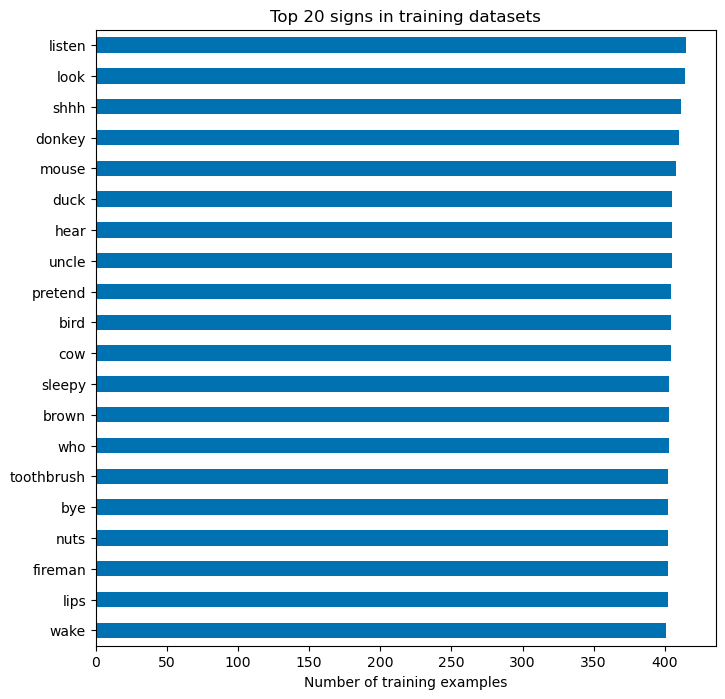

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
train['sign'].value_counts().head(20).sort_values(ascending= True) \
.plot(kind='barh', ax =ax, title='Top 20 signs in training datasets')

ax.set_xlabel('Number of training examples')
plt.show()

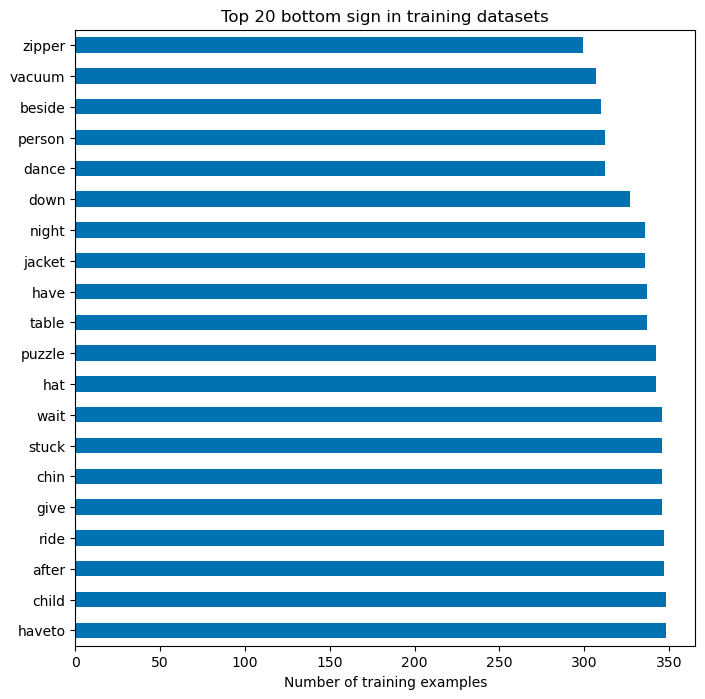

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
train['sign'].value_counts().tail(20).sort_values(ascending = False) \
                                                  .plot(kind='barh', ax=ax, title = 'Top 20 bottom sign in training datasets')
ax.set_xlabel('Number of training examples')
plt.show()

- Train.csv has 250 unique signs
- Ranging from 299 to 415 signs

## Parquet landmark dataset

- Each parquet file in the path:
    - train_landmark_files/[participant_id]/[sequence_id].parquet
    - The parquet's associated sign can be found in train.csv

### Pull an example parquet data

- We pull an example landmark file for the sign 'listen'

In [10]:
example_fn = train.query('sign == "listen"')['path'].values[0]
example_fn

'train_landmark_files/37055/1011397240.parquet'

<IPython.core.display.Javascript object>

In [11]:
landmark_example = pd.read_parquet(f'{BASE_DIR}/{example_fn}')
landmark_example

,frame,row_id,type,landmark_index,x,y,z
0,35,35-face-0,face,0,0.556969,0.431919,-0.039614
1,35,35-face-1,face,1,0.548688,0.394788,-0.077306
2,35,35-face-2,face,2,0.548806,0.405519,-0.040327
3,35,35-face-3,face,3,0.531849,0.356302,-0.058683
4,35,35-face-4,face,4,0.547539,0.382894,-0.082544
...,...,...,...,...,...,...,...
3253,40,40-right_hand-16,right_hand,16,0.177520,0.536142,-0.034433
3254,40,40-right_hand-17,right_hand,17,0.065610,0.493125,-0.047778
3255,40,40-right_hand-18,right_hand,18,0.096587,0.491917,-0.064403
3256,40,40-right_hand-19,right_hand,19,0.125879,0.520035,-0.051628


<IPython.core.display.Javascript object>

In [12]:
unique_frames = landmark_example['frame'].nunique()
unique_types = landmark_example['type'].nunique()
types_in_video = landmark_example['type'].unique()
print(f"The file has {unique_frames} unique frames, {unique_types} unique types and types are {types_in_video}")

The file has 6 unique frames, 4 unique types and types are ['face' 'left_hand' 'pose' 'right_hand']


<IPython.core.display.Javascript object>

In [13]:
listen_files = train.query('sign == "listen"')['path'].values
len(listen_files)

415

<IPython.core.display.Javascript object>

### Comparing parquet files, what type of data we have

- Frames on each record is not consistent.
- Every file has 4 types of landmarks: face, left_hand, right_hand, pose.

In [14]:
for index ,listen in enumerate(listen_files):
    landmark_listen = pd.read_parquet(f"{BASE_DIR}/{listen}")
    unique_frames = landmark_listen['frame'].nunique()
    unique_types = landmark_listen['type'].nunique()
    types_in_video = landmark_listen['type'].unique()
    print(
        f'The listen landmark file {index} has \nunique frames : {unique_frames}, \nunique types :  {unique_types} ,\ntypes: {types_in_video}'
    )
    if index == 20:
        break

The listen landmark file 0 has 
unique frames : 6, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 1 has 
unique frames : 23, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 2 has 
unique frames : 28, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 3 has 
unique frames : 68, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 4 has 
unique frames : 6, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 5 has 
unique frames : 16, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 6 has 
unique frames : 6, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 7 has 
unique frames : 6, 
unique types :  4 ,
types: ['face' 'left_hand' 'pose' 'right_hand']
The listen landmark file 8 has 
uniq

<IPython.core.display.Javascript object>

## Create metadata on training dataset

In [15]:
combined_meta = {}
for index, d in tqdm(train.iterrows(), total=len(train)):
    file_path = d['path']
    landmark_read = pd.read_parquet(f"{BASE_DIR}/{file_path}")
    meta = landmark_read['type'].value_counts().to_dict()
    meta['frame'] = landmark_read['frame'].nunique() ##number of frames in a file
    xyz_meta = (
    landmark_read.agg(
        {
            'x':['min', 'max', 'mean'],
            'y':['min', 'max', 'mean'],
            'z':['min', 'max', 'mean']
        }
    )
    .unstack()
    .to_dict()
    )

    for key in xyz_meta.keys():
        new_keys = key[0] + '_' + key[1]
        meta[new_keys] = xyz_meta[key]
    combined_meta[file_path] = meta
    if index == 1_000:
        break

  0%|          | 0/94477 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [16]:
meta

{'face': 15444,
 'pose': 1089,
 'left_hand': 693,
 'right_hand': 693,
 'frame': 33,
 'x_min': -0.13577386736869812,
 'x_max': 0.9888350963592529,
 'x_mean': 0.4650228190092454,
 'y_min': 0.132933109998703,
 'y_max': 2.1390116214752197,
 'y_mean': 0.33457921685870406,
 'z_min': -1.7977821826934814,
 'z_max': 1.1312501430511475,
 'z_mean': -0.034399142299794426}

<IPython.core.display.Javascript object>

In [17]:
train_with_meta = train.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={'index':'path'}),
    how='left'
)

<IPython.core.display.Javascript object>

In [18]:
train_with_meta

,path,participant_id,sequence_id,sign,face,pose,left_hand,right_hand,frame,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,10764.0,759.0,483.0,483.0,23.0,-0.031811,1.294350,0.536739,0.224151,2.147826,0.383747,-2.782624,1.910815,-0.035692
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,5148.0,363.0,231.0,231.0,11.0,-0.017062,1.015931,0.554794,0.329273,2.222732,0.504912,-2.543970,1.627621,-0.040662
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,49140.0,3465.0,2205.0,2205.0,105.0,-0.042923,1.197836,0.438283,0.248094,2.591290,0.457483,-2.838325,1.587503,-0.047699
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,5616.0,396.0,252.0,252.0,12.0,-0.129268,1.156573,0.478509,0.310272,2.294936,0.503025,-3.018237,2.196296,-0.044505
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,8424.0,594.0,378.0,378.0,18.0,0.072425,1.165405,0.488842,0.405282,2.264609,0.545811,-2.970331,1.360011,-0.054411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [19]:
xyz_meta.keys()

dict_keys([('x', 'min'), ('x', 'max'), ('x', 'mean'), ('y', 'min'), ('y', 'max'), ('y', 'mean'), ('z', 'min'), ('z', 'max'), ('z', 'mean')])

<IPython.core.display.Javascript object>

## EVALUATION 

"The evaluation metric for this contest is simple classification accuracy."